In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

alzheimers-dataset-4-class-of-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

'Alzheimer_s Dataset'   alzheimers-dataset-4-class-of-images.zip   dataset   kaggle.json


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  alzheimers-dataset-4-class-of-images.zip
replace Alzheimer_s Dataset/test/MildDemented/26 (19).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

'Alzheimer_s Dataset'   alzheimers-dataset-4-class-of-images.zip   dataset   kaggle.json


In [ ]:
trainPath = "/content/gdrive/MyDrive/Kaggle/Alzheimer_s Dataset/train"
testPath = "/content/gdrive/MyDrive/Kaggle/Alzheimer_s Dataset/test"

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.xception import Xception
import numpy as np
import pandas as pd


In [ ]:
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#import tensorflow_addons as tfa
#from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.14.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device('/device:GPU:0'):
  IMG_SIZE = 180
  IMAGE_SIZE = [180,180]
  DIM = (IMG_SIZE, IMG_SIZE)
  ZOOM = [.99, 1.01]
  BRIGHT_RANGE = [0.8, 1.2]
  HORZ_FLIP = True
  FILL_MODE = "constant"
  DATA_FORMAT = "channels_last"
  WORK_DIR = "/content/gdrive/MyDrive/Kaggle/Alzheimer_s Dataset/train"
  work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
  train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=5200, shuffle=False)

Found 5121 images belonging to 4 classes.


In [ ]:
with tf.device('/device:GPU:0'):
  train_data, train_labels = train_data_gen.next()

In [ ]:
print(train_data.shape, train_labels.shape)

(5121, 180, 180, 3) (5121, 4)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced
with tf.device('/device:GPU:0'):
  sm = SMOTE(random_state=42)

  train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

  train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

  print(train_data.shape, train_labels.shape)

(10240, 180, 180, 3) (10240, 4)


In [ ]:
with tf.device('/device:GPU:0'):
  #Splitting the data into train, test, and validation sets

  train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
  train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(6553, 180, 180, 3)
(1639, 180, 180, 3)
(2048, 180, 180, 3)


In [ ]:
with tf.device('/device:GPU:0'):
  #Model building
  xcept_model = Xception(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

In [ ]:
with tf.device('/device:GPU:0'):
  for layer in xcept_model.layers:
    layer.trainable=False

In [ ]:
with tf.device('/device:GPU:0'):
  # Creating sequential layers

  custom_inception_model = Sequential([
      xcept_model,
      Dropout(0.5),
      GlobalAveragePooling2D(),
      Flatten(),
      BatchNormalization(),
      Dense(512, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(256, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(128, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dropout(0.5),
      BatchNormalization(),
      Dense(4, activation='softmax')
    ], name = "inception_cnn_model")

In [ ]:
with tf.device('/device:GPU:0'):
  METRICS = [
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
       tf.keras.metrics.AUC(name='auc')
  ]

# CALLBACKS = rop_callback

  custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

  custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [ ]:
with tf.device('/device:GPU:0'):
  # Train the model
  history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=30)

Epoch 1/30
205/205 [==============================] - 44s 127ms/step - loss: 1.4080 - accuracy: 0.4204 - precision: 0.4789 - recall: 0.3142 - auc: 0.6924 - val_loss: 0.8861 - val_accuracy: 0.5937 - val_precision: 0.7834 - val_recall: 0.3618 - val_auc: 0.8597
Epoch 2/30
205/205 [==============================] - 22s 108ms/step - loss: 0.9248 - accuracy: 0.5869 - precision: 0.6742 - recall: 0.4557 - auc: 0.8471 - val_loss: 0.6958 - val_accuracy: 0.6779 - val_precision: 0.8104 - val_recall: 0.4930 - val_auc: 0.9099
Epoch 3/30
205/205 [==============================] - 23s 112ms/step - loss: 0.8004 - accuracy: 0.6345 - precision: 0.7411 - recall: 0.4940 - auc: 0.8828 - val_loss: 0.6674 - val_accuracy: 0.6931 - val_precision: 0.8211 - val_recall: 0.5125 - val_auc: 0.9160
Epoch 4/30
205/205 [==============================] - 22s 107ms/step - loss: 0.7229 - accuracy: 0.6664 - precision: 0.7742 - recall: 0.5237 - auc: 0.9038 - val_loss: 0.6260 - val_accuracy: 0.6974 - val_precision: 0.8361 - v

In [ ]:
custom_inception_model.save('adp.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


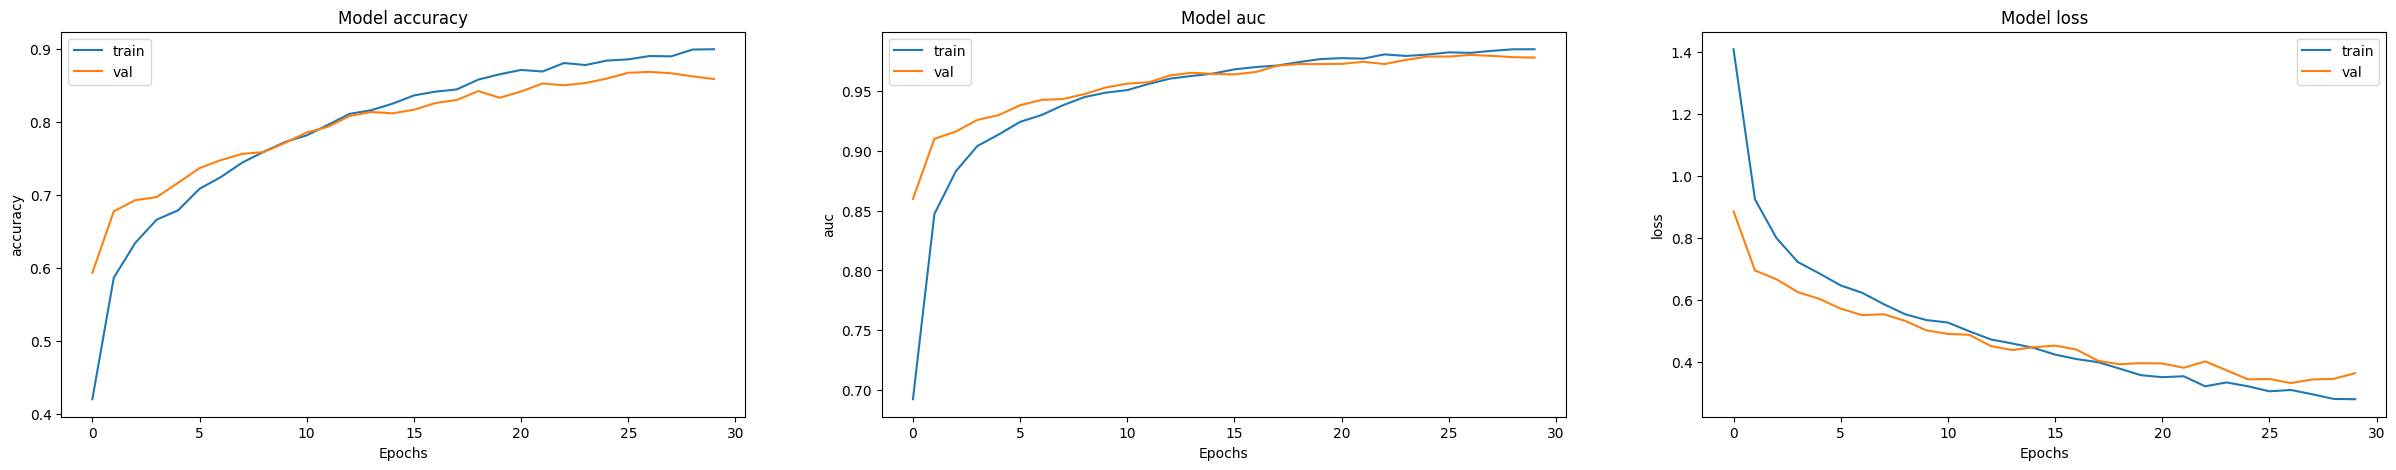

In [ ]:
with tf.device('/device:GPU:0'):
  fig, ax = plt.subplots(1, 3, figsize = (30, 5))
  ax = ax.ravel()

  for i, metric in enumerate(["accuracy", "auc", "loss"]):
      ax[i].plot(history.history[metric])
      ax[i].plot(history.history["val_" + metric])
      ax[i].set_title("Model {}".format(metric))
      ax[i].set_xlabel("Epochs")
      ax[i].set_ylabel(metric)
      ax[i].legend(["train", "val"])